In [2]:
# Script for formatting the Copy-scAT output into epiAneufinder bins
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from natsort import natsorted
import gzip

In [3]:
chrarm = pd.read_csv("hg38_cytoBand.txt", sep="\t", header=0, names=["chr","start","end","arm_annot","comment"])
chrarm = chrarm.dropna()
chrarm = chrarm.reset_index(drop=True)

armannot = []
for idx, elem in enumerate(chrarm["arm_annot"]):
    chrarm["chr"][idx] = chrarm["chr"][idx]+elem[0]

<ipython-input-3-2109256a96c4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chrarm["chr"][idx] = chrarm["chr"][idx]+elem[0]


In [4]:
del chrarm["arm_annot"]
del chrarm["comment"]

In [5]:
chrarm = chrarm.groupby(['chr']).agg({'start': ['min'], 'end': lambda x: max(x)-1})

In [6]:
chrarm.columns = ["start","end"]

In [7]:
chrarm.loc["chr1p"].start = 0

In [8]:
chrarm["tmp"] = chrarm.index

In [9]:
chrom = []
arm = []
for elem in chrarm["tmp"]:
    chrom.append(elem[:-1])
    arm.append(elem[-1])
chrarm["seq"] = chrom
chrarm["arm"] = arm

In [10]:
armdict = {}
for idx, elem in enumerate(chrarm["tmp"]):
    armdict[elem] = [chrarm["start"][idx], chrarm["end"][idx]]

In [11]:
epidf = pd.read_csv("epiAneufinder/aGBM_4349_results_table.tsv", sep=" ")

In [12]:
annot = []
for idx, chrom in enumerate(epidf["seq"]):
    chrom = str(chrom)
    if epidf["start"].tolist()[idx] >= 0 and epidf["end"].tolist()[idx] <= chrarm.loc[:str(chrom)+"p"].end[str(chrom)+"p"]+1:
        annot.append(chrom+"p")
    elif epidf["start"].tolist()[idx] >= chrarm.loc[:str(chrom)+"q"].start[str(chrom)+"q"]:
        annot.append(chrom+"q")
    else:
        annot.append("unclear")

In [13]:
epidf["arm"] = annot

In [14]:
epidf.columns = epidf.columns.str.replace(r'cell-', '')

In [15]:
data = pd.read_csv("CopyscAT/aGBM_4349_1Mb_5000clean_cnv_cnv_scores.csv", index_col=0)

df = data.reindex(natsorted(data.columns), axis=1)

In [16]:
df_copy = df.T

In [17]:
df_copy["arm"] = df_copy.index

In [18]:
chrom = []
starts = []
ends = []
for idx,elem in enumerate(epidf.arm.tolist()):
    chrom.append(elem)
    starts.append(epidf["start"][idx+1])
    ends.append(epidf["end"][idx+1])

In [19]:
binsizes = pd.DataFrame()
binsizes.index = chrom
binsizes["arm"] = chrom
binsizes["start"] = starts
binsizes["end"] = ends

In [20]:
csa = pd.merge(binsizes, df_copy, on="arm")

In [21]:
copy_position = []
for idx, elem in enumerate(csa["arm"]):
    copy_position.append(elem[:-1]+"_"+str(csa["start"][idx])+"_"+str(csa["end"][idx]))

In [22]:
csa["position"] = copy_position

In [23]:
epi_position = []
for idx, elem in enumerate(epidf["seq"]):
    epi_position.append(elem+"_"+str(epidf["start"][idx+1])+"_"+str(epidf["end"][idx+1]))

In [24]:
epidf["position"] = epi_position

In [25]:
del csa["arm"]
del csa["start"]
del csa["end"]

In [26]:
csa.index = csa["position"]

In [27]:
del epidf["arm"]
del epidf["seq"]
del epidf["start"]
del epidf["end"]

In [28]:
del csa["position"]

In [29]:
#csa.T.to_csv("aGBM_4349_copyscat_means_per_epiAneufinder_bins_per_cell_20230321.tsv", sep="\t")

In [30]:
epidf.index = epidf["position"]

In [31]:
del epidf["position"]

In [32]:
epi = epidf.T
csa1 = csa.T

In [33]:
kept_cells = []
for elem in csa1.index.tolist():
    if elem in epi.index.tolist():
        kept_cells.append(elem)

In [34]:
len(kept_cells)

702

In [35]:
new_csa = csa1[csa1.index.isin(kept_cells)]

In [36]:
new_epi = epi[epi.index.isin(kept_cells)]

In [37]:
kept_cols = []
for elem in new_epi.columns.tolist():
    if elem in new_csa.columns.tolist():
        kept_cols.append(elem)

In [38]:
len(kept_cols)

12745

In [39]:
new_epi = new_epi.filter(kept_cols, axis="columns")

In [40]:
new_epi = new_epi + 1

In [41]:
new_csa = new_csa.filter(kept_cols, axis="columns")

In [42]:
sorterIndex = dict(zip(new_csa.index.tolist(), range(len(new_csa.index.tolist()))))

In [43]:
new_epi['cell_rank'] = new_epi.index.map(sorterIndex)

In [44]:
new_epi.sort_values(["cell_rank"], inplace = True)
new_epi.drop('cell_rank', 1, inplace = True)

<ipython-input-44-37488d35b2ed>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  new_epi.drop('cell_rank', 1, inplace = True)


In [45]:
new_epi = new_epi.astype(float)

In [46]:
cor_df = pd.DataFrame(new_epi.corrwith(new_csa, axis = 0))

In [47]:
pd.DataFrame(np.mean(new_epi, axis=0)).corrwith(np.mean(new_csa, axis=0))

0    0.417765
dtype: float64

In [48]:
df1 = pd.DataFrame()

df1["position"] = 2*new_csa.columns.tolist()

means = []
dataset = []
for elem in np.mean(new_csa, axis=0).tolist():
    means.append(elem)
    dataset.append("copyscat")
for elem in np.mean(new_epi, axis=0).tolist():
    means.append(elem)
    dataset.append("epianeufinder")
df1["means"] = means
df1["method"] = dataset

In [49]:
#df1[df1["method"] == "copyscat"].to_csv("aGBM_4349_copyscat_means_per_epiAneufinder_bins_20230321.tsv", sep="\t")

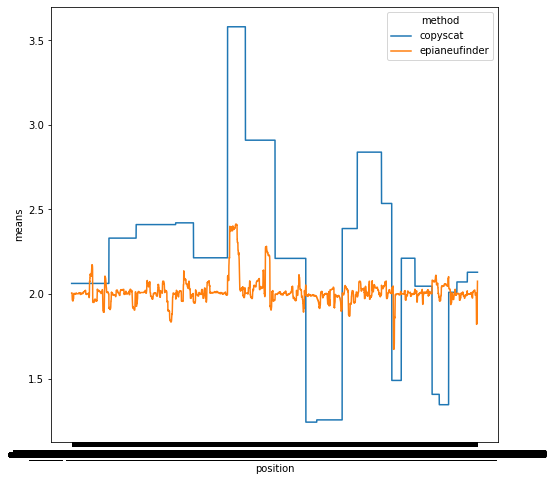

In [50]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
ax = sns.lineplot(df1, x="position", y="means", hue="method")